# Task 

For this assignment, you will revisit your first project to predict supermarket sales. You will apply what you've learned this week to explain how your models made their predictions.

## Project 1 Revisited - Part 1: Remaking, Saving, and Explaining Your Models

For this part of the project, you will be producing a new version of your final project notebook using the updated tools in sklearn v1.1. 

- Create a new notebook called "Project 1 - Revisited.ipynb" in your project repo.
 - You may either make a copy of your prior notebook that you will modify, or you can start a new blank notebook and copy over the code from your old notebook (as needed).
- Remake your X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.

## LinearRegression
- Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.
- Extract and visualize the coefficients that your model determined.
 - Select the top 3 most impactful features and interpret their coefficients in plain English.
- Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).

## Tree-Based Model
- Fit and evaluate your tree-based regression model using your dataframe X_train and X_test data.
- Extract and visualize the feature importances that your model determined.
 - Identify the top 5 most important features.
- Save your figure as a .png file inside your repository  (you will need this for the final piece of this assignment - Update Your README).

## Serialize Your Best Models with Joblib
- Once you've finished updating and explaining your models, you must save the following key: value pairs as a dictionary in a joblib file named "best-models.joblib":
 - "preprocessor": your preprocessing  column transformer
 - "X_train": your training features.
 - "X_test": your test features.
 - "y_train": your training target.
 - "y_test": your test target.
 - "LinearRegression": your best linear regression
 - Your tree-based model's class name: your best tree-based model.
   - e.g. "RandomForestRegressor"/"DecisionTreeRegressor"
 - Save your joblib file inside your repository. (You will work with these models again in the next core assignment.)

## Update your README.
- Insert your exported figures from above into your README file. You should have the following:
 - Your LinearRegression coefficients plot.
   - Your interpretation of your coefficients.
 - Your tree-based model's feature importances.
   - Your interpretation of your feature importances. 


- Submit the link to your project repository as your final submission.

# Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 42
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Run the following command on your local computer to check the version of sklearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.1.3


# Functions

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [4]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [5]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [6]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [7]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, annotate = True):
    
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [8]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

# Data Loading

In [9]:
filename = '/Users/jasontracey/Documents/GitHub/Project-1-Revisited/Data/sales_predictions.csv'
df = pd.read_csv(filename)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Data Cleaning

In [11]:
df.drop_duplicates(keep = 'first', inplace = True)

In [12]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [13]:
df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat' : 'Low Fat', 'reg' : 'Regular'}, inplace = True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [14]:
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [15]:
df['Outlet_Size'].replace({'High': 'Large'}, inplace = True)
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

# Train Test Split

In [16]:
target = 'Item_Outlet_Sales'
X = df.drop(columns = [target, 'Item_Identifier']).copy()
y = df[target].copy()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


In [18]:
y_train.head()

4776     515.3292
7510    3056.0220
5828    1577.9460
5327    1331.6000
4810    1687.1372
Name: Item_Outlet_Sales, dtype: float64

# Preprocessing

## Numerical Columns

In [19]:
median_imputer = SimpleImputer(strategy = 'median')
scaler = StandardScaler()

numerical_pipeline = make_pipeline(median_imputer) # ignore scaler , scaler)

numerical_selector = ['Item_Weight', 'Item_Visibility', 'Item_MRP']

numerical_tuple = (numerical_pipeline, numerical_selector)

## Nominal Columns

In [20]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
constant_imputer = SimpleImputer(strategy='constant', fill_value='missing')

nominal_pipeline = make_pipeline(constant_imputer, ohe)

nominal_selector = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Establishment_Year']

nominal_tuple = (nominal_pipeline, nominal_selector)

## Ordinal Columns

In [21]:
size_list = ['Small', 'Medium', 'Large']
location_type_list = ['Tier 1', 'Tier 2', 'Tier 3']
type_list = ['Grocery Store', 'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3']

odie = OrdinalEncoder(categories=[size_list, location_type_list, type_list])
frequent_imputer = SimpleImputer(strategy='most_frequent')
scaler2 = StandardScaler()

ordinal_pipeline = make_pipeline(frequent_imputer, odie) # ignore scaler, scaler2)

ordinal_selector = ['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

ordinal_tuple = (ordinal_pipeline, ordinal_selector)

In [22]:
preprocessor = make_column_transformer(ordinal_tuple, nominal_tuple, numerical_tuple, 
                                       remainder='passthrough', verbose_feature_names_out=False)
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'Large'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '3'],
                                                                             ['Grocery '
                                                                              'Store',
                                                                              'Supermarket '
                                                                              'Type1',
                                                                              'Supermarket '
                                                                              'Type2',
                                                                              'Supermarket '
                                                                              'Type3']]))]),
                                 ['Outlet_Size',...
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Identifier',
                                  'Outlet_Establishment_Year']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Item_Weight', 'Item_Visibility',
                                  'Item_MRP'])],
                  verbose_feature_names_out=False)

In [23]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Establishment_Year_1985', 'Outlet_Establishment_Year_1987',
       'Outlet_Establishment_Year_1997', 'Outlet_Est

 # Create DataFrames for X_train & X_test

In [24]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head()

,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Establishment_Year_1985,Outlet_Establishment_Year_1987,Outlet_Establishment_Year_1997,Outlet_Establishment_Year_1998,Outlet_Establishment_Year_1999,Outlet_Establishment_Year_2002,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009,Item_Weight,Item_Visibility,Item_MRP
4776,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.350,0.029565,256.4646
7510,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.250,0.000000,179.7660
5828,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.350,0.158716,157.2946
5327,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.975,0.014628,82.3250
4810,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,19.350,0.016645,120.9098


In [25]:
## confirm the first 5 rows index in y_train matches X_train_df
y_train.head()

4776     515.3292
7510    3056.0220
5828    1577.9460
5327    1331.6000
4810    1687.1372
Name: Item_Outlet_Sales, dtype: float64

In [26]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head()

,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Establishment_Year_1985,Outlet_Establishment_Year_1987,Outlet_Establishment_Year_1997,Outlet_Establishment_Year_1998,Outlet_Establishment_Year_1999,Outlet_Establishment_Year_2002,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009,Item_Weight,Item_Visibility,Item_MRP
7503,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.300,0.026300,79.4302
2957,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.930,0.071136,42.7086
7031,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.500,0.041313,42.0454
1084,1.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.650,0.044767,173.7054
856,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.195,0.012456,197.5110


In [27]:
## confirm the first 5 rows index in y_test matches X_test_df
y_test.head()

7503    1743.0644
2957     356.8688
7031     377.5086
1084    5778.4782
856     2356.9320
Name: Item_Outlet_Sales, dtype: float64

# Linear Regression

In [28]:
lin_reg = LinearRegression()

# fit
lin_reg.fit(X_train_df, y_train)

LinearRegression()

In [29]:
# evaluate
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


## Extract Coefficients

In [30]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

intercept                         -1072.551341
Outlet_Identifier_OUT019           -467.652340
Item_Visibility                    -423.390180
Outlet_Establishment_Year_2009     -391.621201
Outlet_Identifier_OUT018           -391.621201
Outlet_Identifier_OUT010           -324.442787
Outlet_Establishment_Year_1998     -324.442787
Outlet_Establishment_Year_1985     -219.792023
Item_Type_Dairy                    -124.947555
Outlet_Location_Type               -123.158092
Item_Type_Soft Drinks               -58.098276
Item_Type_Breads                    -47.260859
Item_Type_Others                    -45.426266
Item_Type_Snack Foods               -40.544933
Item_Fat_Content_Low Fat            -31.312617
Item_Type_Meat                      -30.477427
Item_Type_Frozen Foods              -20.383167
Item_Type_Baking Goods              -18.612541
Item_Type_Household                 -13.102794
Item_Type_Hard Drinks                -4.717641
Item_Weight                          -1.941817
Item_Type_Hea

## Visualize 3 most Impactful Features

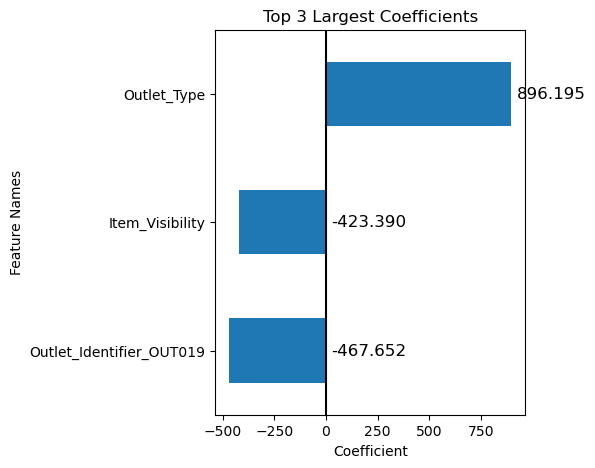

In [31]:
ax = plot_coeffs(coeffs, top_n = 3, intercept = False, annotate = True)
annotate_hbars(ax);

## Analysis

If the observation belongs to `Outlet_Type`, then the target sales will increase by 896.195 rupees. The type of store you have can increase your sales. 

If the observation belongs to `Item Visibility`, then the target sales will decrease by 423.390 rupees. If items are not visible, it will hinder sales.

If the observation belongs to `Outlet_Identifier_OUT019`, then the target sales will decrease by 467.652 rupees. This store can hinder sales.

## Save Image

In [32]:
fig = ax.get_figure()
fig.savefig('Images/Lin_Reg_3_Largest_Coefficients.png',
           bbox_inches = 'tight')

# Decision Tree

In [33]:
#Decision Tree
decision_tree = DecisionTreeRegressor(random_state = SEED) # creates instance of the model

decision_tree.fit(X_train_df, y_train) 

DecisionTreeRegressor(random_state=42)

In [35]:
# evaluate
evaluate_regression(decision_tree, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.15	RMSE= 1531.52


## Extract Feature Importances

In [38]:
importances = get_importances(decision_tree, feature_names=None,name='Dec_Tree Feature Importance',
                   sort=True, ascending=True)

importances

Outlet_Establishment_Year_1998     0.000002
Outlet_Identifier_OUT019           0.000003
Outlet_Identifier_OUT010           0.000017
Outlet_Establishment_Year_2009     0.001375
Outlet_Establishment_Year_1997     0.001548
Item_Type_Seafood                  0.001666
Outlet_Identifier_OUT018           0.001792
Outlet_Identifier_OUT017           0.001931
Outlet_Establishment_Year_2004     0.001945
Item_Type_Others                   0.002057
Outlet_Establishment_Year_2002     0.002143
Outlet_Identifier_OUT046           0.002191
Outlet_Establishment_Year_1999     0.002296
Item_Type_Breads                   0.002347
Outlet_Identifier_OUT027           0.002400
Outlet_Identifier_OUT035           0.002435
Item_Type_Breakfast                0.002462
Item_Type_Meat                     0.002508
Item_Type_Hard Drinks              0.002663
Outlet_Identifier_OUT045           0.003042
Item_Type_Starchy Foods            0.003101
Outlet_Establishment_Year_1987     0.003377
Item_Type_Baking Goods          

## Visualize 5 most Important Features

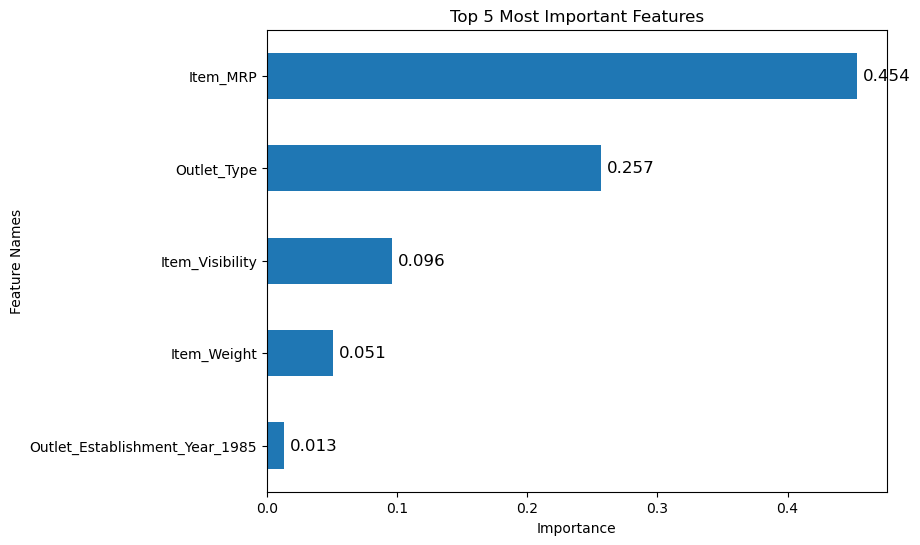

In [41]:
# plot top 5 importances
ax = plot_importance(importances, top_n = 5)
annotate_hbars(ax);

## Analysis

The most important feature for the Decision Tree Model is `Item_MRP`, with a feature importance of about 0.45. This means that the model relied on this feature to make its decisions to split nodes about 45% of the time.

The other top features were `Outlet_Type`, `Item_Visibility`, `Item_Weight`, and `Outlet_Establishment_Year_1985`. The model made decisions based on these features 25%, 10%, 5% and 1% respectively. These features account for the majority of the decisions made by the model at any given time. `Outlet_Type` and `Item_Visibility` were also important in the Linear Regression model.

## Save Image

In [40]:
fig = ax.get_figure()
fig.savefig('Images/Dec_Tree_5_Most_Important_Features.png',
           bbox_inches = 'tight')

# Serialization

In [43]:
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
         'DecisionTreeRegressor': decision_tree}

joblib.dump(export, 'Best_Models.joblib')

['Best_Models.joblib']

In [44]:
loaded = joblib.load('Best_Models.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'DecisionTreeRegressor'])